In [1]:
from itertools import islice
from tqdm import tqdm
from pprint import pprint
from IPython.display import Image, display
import random

from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

from amazonutils import *

## Connect to Elasticsearch

In [2]:
!curl localhost:9200

{
  "name" : "elasticsearch_master",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "53DiC7P_TIGD_vArFzObYg",
  "version" : {
    "number" : "7.9.3",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "c4138e51121ef06a6404866cddc601906fe5c868",
    "build_date" : "2020-10-16T10:36:16.141335Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [3]:
es = Elasticsearch(["http://localhost:9200"])
es.cluster.health(wait_for_status='yellow', request_timeout=1)

{'cluster_name': 'docker-cluster',
 'status': 'yellow',
 'timed_out': False,
 'number_of_nodes': 2,
 'number_of_data_nodes': 1,
 'active_primary_shards': 1,
 'active_shards': 1,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 1,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 50.0}

<br><br><br><br><br><br><br><br><br><br><br><br>

## Explore the Data

{'asin': '1094780162',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Men',
                 'Watches',
                 'Wrist Watches']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51c8R8f-2AL._SY300_.jpg',
 'price': 19.15,
 'related': {'buy_after_viewing': ['B00AAAH0Y4', 'B0056XGM94', 'B008HBKJV4']},
 'title': 'Men Automatic U1 Skeleton Mechanical Watch Metal/Leather'}


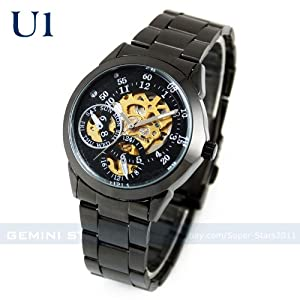

B000IG9NS6 4096 [0.0, 0.608299970626831, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4700000286102295, 0.0, 0.0, 0.8876000046730042, 0.0, 0.3767000138759613]


In [4]:
fname_products = "meta_Clothing_Shoes_and_Jewelry.json.gz"
fname_vectors = "image_features_Clothing_Shoes_and_Jewelry.b"

p = next(islice(iter_products(fname_products), 20, 21))
pprint(p)
display(Image(p['imUrl'], width=128, height=128))

asin, vec = next(iter_vectors(fname_vectors))
print(asin, len(vec), vec[:20])

<br><br><br><br><br><br><br><br><br><br><br><br>

## Index the Products

In [5]:
index = "amazon-products-demo"

mapping = {
  "dynamic": False,
  "properties": {
    
    "asin": { "type": "keyword" },
    "title": { "type": "text" },
    "description": { "type": "text" },
    "imUrl": { "type": "text" },
    "price": { "type": "float" },
    
    "imVec": {
      "type": "elastiknn_dense_float_vector",
      "elastiknn": {
        "dims": 4096
      }
    } 
  }
}

if es.indices.exists(index):
  es.indices.delete(index)
es.indices.create(index)
es.indices.put_mapping(mapping, index)

es.indices.get_mapping(index)

{'amazon-products-demo': {'mappings': {'dynamic': 'false',
   'properties': {'asin': {'type': 'keyword'},
    'description': {'type': 'text'},
    'imUrl': {'type': 'text'},
    'imVec': {'type': 'elastiknn_dense_float_vector',
     'elastiknn': {'dims': 4096}},
    'price': {'type': 'float'},
    'title': {'type': 'text'}}}}}

In [6]:
def index_actions(index, n=600):
  asin2vec = { asin: vec for asin, vec in islice(iter_vectors(fname_vectors), n) } 
  piter = iter_products(fname_products)
  indexed = 0
  while indexed < n:
    p = next(piter)
    if p['asin'] in asin2vec:
      vec = asin2vec[p['asin']]
      action = {
        "_op_type": "index", 
        "_index": index, 
        "_id": p["asin"], 
        
        "asin": p["asin"], 
        "title": p.get("title", None), 
        "description": p.get("description", None),
        "price": p.get("price", None),
        "imUrl": p.get("imUrl", None),
        
        "imVec": vec # [0.1, 0.2, 0.3]
      }
      indexed += 1
      yield action

bulk(es, tqdm(index_actions(index)), chunk_size=100, max_retries=2)
es.indices.refresh(index)
!curl localhost:9200/{index}/_count

600it [00:05, 107.42it/s]


{"count":600,"_shards":{"total":1,"successful":1,"skipped":0,"failed":0}}

In [7]:
!curl localhost:9200/{index}/_search?size=1\&pretty

{
  "took" : 1,
  "timed_out" : false,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  },
  "hits" : {
    "total" : {
      "value" : 600,
      "relation" : "eq"
    },
    "max_score" : 1.0,
    "hits" : [
      {
        "_index" : "amazon-products-demo",
        "_type" : "_doc",
        "_id" : "B00076MHZI",
        "_score" : 1.0,
        "_source" : {
          "asin" : "B00076MHZI",
          "title" : "Tommy Hilfiger Men's Multi Athletic Crew Socks, White/Grey/Black, 3-Pack",
          "description" : null,
          "price" : null,
          "imUrl" : "http://ecx.images-amazon.com/images/I/41TC1QQPXYL._SX342_.jpg",
          "imVec" : [
            0.0,
            0.0,
            8.093299865722656,
            0.0,
            0.5802000164985657,
            0.0,
            0.0,
            0.0,
            0.8270000219345093,
            0.0,
            0.0,
            4.319900035858154,
            0.0,
            0.0,
   

<br><br><br><br><br><br><br><br><br><br><br><br>

## Look at Some Random Products

In [8]:
body = {
  "query": {
    "function_score": {
      "query": { "match_all": {} },
      "random_score": {}
    }
  }
}

res = es.search(index=index, body=body, size=5)
display_hits_horizontal(res)

Found 600 hits in 2 ms. Showing top 5.


"B000F72CCC, 0.9956748","B000FGWTMG, 0.9939545","B000FGLOIQ, 0.9936114","B0007IFQFE, 0.99194014","B000FIS6O4, 0.9917373"


<br><br><br><br><br><br><br><br><br><br><br><br>

## Standard Full Text Search

In [9]:
body = {
  "query": {
    "multi_match": {
      "query": "men's watch",
      "fields": ["title^2", "description"]
    }
  }
}

res = es.search(index=index, body=body, size=5)
display_hits_horizontal(res)

Found 155 hits in 4 ms. Showing top 5.


"B0007N53MU, 9.54347","B000EQVZ6S, 9.54347","B000FQCOOO, 9.54347","B000F08GKG, 8.980126","B000F6SOYS, 8.980126"


<br><br><br><br><br><br><br><br><br><br><br><br>

## Exact Nearest Neighbors Query


In [10]:
product_id = "B000FQCOOO"
fetch_res = es.get(index=index, id=product_id)
query_vec = fetch_res['_source']['imVec']
str(query_vec)[:100]

'[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1623001098632812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,'

In [11]:
body = {
  "query": {
    "elastiknn_nearest_neighbors": {
      "vec": query_vec,
      "field": "imVec",
      "similarity": "angular",
      "model": "exact"
    }
  }
}

res = es.search(index=index, body=body, size=5)
display_hits_horizontal(res)

Found 600 hits in 37 ms. Showing top 5.


"B000FQCOOO, 2.0","B000FVC5NE, 1.7845466","B000BH5SY0, 1.7213446","B0007LNK0O, 1.6862981","B000F08GKG, 1.6541722"


<br><br><br><br><br><br><br><br><br><br><br><br>

## Index the Products (For Approximate Queries)

In [12]:
index = "amazon-products-demo"

mapping = {
  "dynamic": False,
  "properties": {
    "asin": { "type": "keyword" },
    "title": { "type": "text" },
    "description": { "type": "text" },
    "imUrl": { "type": "text" },
    "price": { "type": "float" },
    
    "imVec": {
      "type": "elastiknn_dense_float_vector",
      "elastiknn": {
        "dims": 4096,
        "similarity": "angular",
        "model": "lsh",
        "L": 60,
        "k": 3
      }
    }
    
  }
}

if es.indices.exists(index):
  es.indices.delete(index)
es.indices.create(index)
es.indices.put_mapping(mapping, index)

es.indices.get_mapping(index)

{'amazon-products-demo': {'mappings': {'dynamic': 'false',
   'properties': {'asin': {'type': 'keyword'},
    'description': {'type': 'text'},
    'imUrl': {'type': 'text'},
    'imVec': {'type': 'elastiknn_dense_float_vector',
     'elastiknn': {'model': 'lsh',
      'similarity': 'angular',
      'dims': 4096,
      'L': 60,
      'k': 3}},
    'price': {'type': 'float'},
    'title': {'type': 'text'}}}}}

In [13]:
bulk(es, tqdm(index_actions(index)), chunk_size=100, max_retries=2)
es.indices.refresh(index)
!curl localhost:9200/{index}/_count

600it [00:05, 100.51it/s]


{"count":600,"_shards":{"total":1,"successful":1,"skipped":0,"failed":0}}

In [14]:
!curl localhost:9200/{index}/_search?size=1\&pretty

{
  "took" : 1,
  "timed_out" : false,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  },
  "hits" : {
    "total" : {
      "value" : 600,
      "relation" : "eq"
    },
    "max_score" : 1.0,
    "hits" : [
      {
        "_index" : "amazon-products-demo",
        "_type" : "_doc",
        "_id" : "B00076MHZI",
        "_score" : 1.0,
        "_source" : {
          "asin" : "B00076MHZI",
          "title" : "Tommy Hilfiger Men's Multi Athletic Crew Socks, White/Grey/Black, 3-Pack",
          "description" : null,
          "price" : null,
          "imUrl" : "http://ecx.images-amazon.com/images/I/41TC1QQPXYL._SX342_.jpg",
          "imVec" : [
            0.0,
            0.0,
            8.093299865722656,
            0.0,
            0.5802000164985657,
            0.0,
            0.0,
            0.0,
            0.8270000219345093,
            0.0,
            0.0,
            4.319900035858154,
            0.0,
            0.0,
   

<br><br><br><br><br><br><br><br><br><br><br><br>

## Approximate Nearest Neighbors Query

In [15]:
body = {
  "query": {
    "elastiknn_nearest_neighbors": {
      "vec": query_vec,
      "field": "imVec",
      "similarity": "angular",
      "model": "lsh",
      "candidates": 100
    }
  }
}

res = es.search(index=index, body=body, size=5)
display_hits_horizontal(res)

Found 500 hits in 39 ms. Showing top 5.


"B000FQCOOO, 2.0","B000FVC5NE, 1.7845466","B000BH5SY0, 1.7213446","B0007LNK0O, 1.6862981","B000F08GKG, 1.6541722"


<br><br><br><br><br><br><br><br><br><br><br><br>

## Combine Standard and Nearest Neighbors Queries

In [16]:
body = {
  "query": {
    "multi_match": {
      "query": "leather",
      "fields": ["title^2", "description"]
    }
  }
}

res = es.search(index=index, body=body, size=5)
display_hits_horizontal(res)

Found 30 hits in 3 ms. Showing top 5.


"B000BT0J24, 7.5574436","B000F5M120, 7.111333","B000F6UVK8, 7.111333","B0007WE9F8, 6.714954","B000F1NFYW, 6.714954"


In [17]:
body = {
  "query": {
    "function_score": {
      "query": {
        "multi_match": {
          "query": "leather",
          "fields": ["title^2", "description"]
        }
      },
      "boost_mode": "replace",
      "functions": [
        {
          "elastiknn_nearest_neighbors": {
            "field": "imVec",
            "similarity": "angular",
            "model": "exact",
            "vec": query_vec
          }
        }
      ]
    }
  }
}

res = es.search(index=index, body=body, size=5)
display_hits_horizontal(res)

Found 30 hits in 26 ms. Showing top 5.


"B000EX8UX2, 1.6438068","B0007N52ZS, 1.5568341","B000FVC502, 1.4487277","B000F99DKE, 1.4421068","B000FNROXS, 1.4001399"
